In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
from time import time

# Poisson depending on (truncated) Gaussian Rate

Let $R$ be a Gaussian with mean $\mu = 5$, std $\sigma = 1$ truncated to $[0, +\infty)$ and consider a Poisson distribution with rate $R$, i.e. $K \sim Pois(R)$. Then

$$ P(K=k) = \int_0^\infty P(K=k | R=r)P(R=r)dr =  \frac{1}{k! \sqrt{2\pi\sigma^2}} \int_0^\infty r^ke^{-r}e^{-\frac{(r-\mu)^2}{2\sigma^2}} dr $$

## Density computed with simpy

Distribution computed by sympy in:  0.93


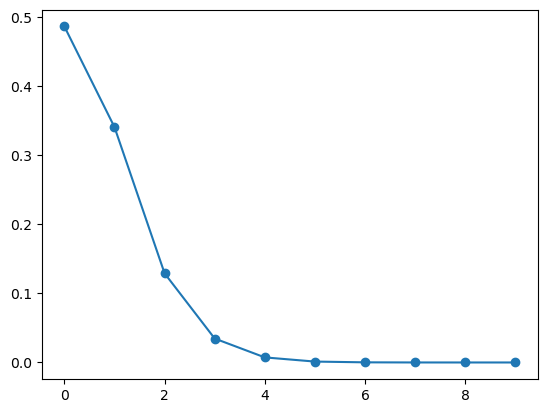

In [4]:
from sympy import *

r = symbols('r', positive=True)
k = symbols('k', positive=True)
mu = 0.7402125879800838
sigma = np.sqrt(0.03999107210133827)

supp = 10
pois = np.zeros(supp)

start = time()
f = 1/(factorial(k) * sqrt(2*pi*sigma**2))* r**k * exp(-r) * exp(-(r-mu)**2 / (2*sigma**2))
F = integrate(f,(r,0,oo))

for k_val in range(supp):
    pois[k_val] = re(F.subs(k,k_val).evalf())
np.array(pois).astype(float)

pois = pois/sum(pois)

end = time()
print('Distribution computed by sympy in: ', np.round(end-start,2))


plt.plot(range(supp), pois, marker='o', label='simpy')

##  Density computed with iterative formulas

Distribution computed by iterative formulas in:  0.0


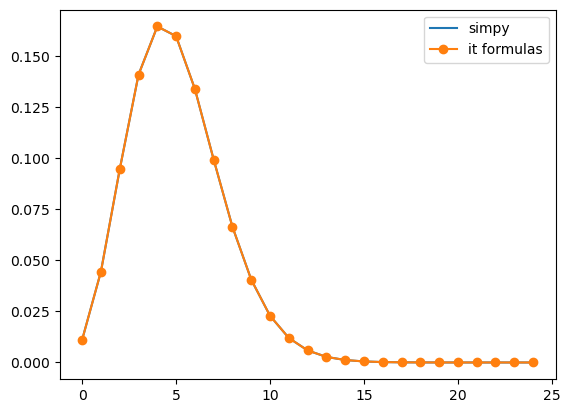

In [250]:
pois_it = np.zeros(supp)

start = time()
muprime = mu - sigma**2
for k_val in range(supp):
    if k_val ==0:
        pois_it[k_val] = 1 - norm.cdf(-muprime/sigma)
    elif k_val == 1:
        pois_it[k_val] = muprime*pois_it[k_val-1] + sigma*norm.pdf(-muprime/sigma)
    else:
        pois_it[k_val] = (muprime*pois_it[k_val-1] + (k_val-1)*(sigma**2)*pois_it[k_val-2])

fact = np.array([np.math.factorial(k_val) for k_val in range(supp)])
pois_it = pois_it/fact
pois_it = pois_it/sum(pois_it)

end = time()
print('Distribution computed by iterative formulas in: ', np.round(end-start,2))

plt.plot(range(supp), pois, label='simpy')
plt.plot(range(supp), pois_it, marker='o', label='it formulas')
plt.legend()
        

Approssimare con binomiale negativa poi sommare

## Moment-matching of order 2 (mean and variance/mode and variance)

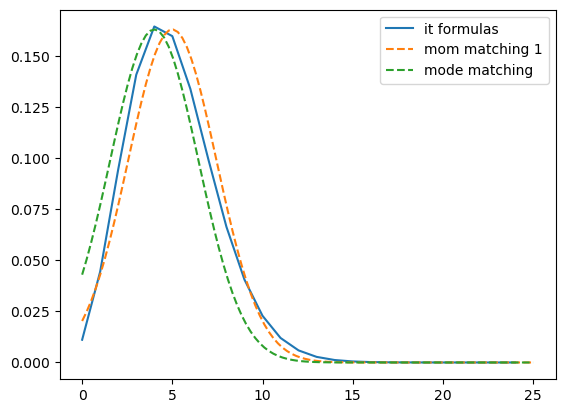

In [179]:
x = np.linspace(0,supp,100)
loc1 = np.array(range(supp)).dot(pois_it)
loc2 = list(pois_it).index(max(pois_it))
scale = np.sqrt((np.array(range(supp))**2).dot(pois_it)-loc1**2)



#plt.plot(range(supp), pois, label='simpy')
plt.plot(range(supp), pois_it, label='it formulas')
plt.plot(x, norm.pdf(x, loc1, scale), ls='--', label='mom matching 1')
plt.plot(x, norm.pdf(x, loc2, scale), ls='--', label='mode matching')
plt.legend()

## Fitting a GM with 2 components (Expectation Maximization)

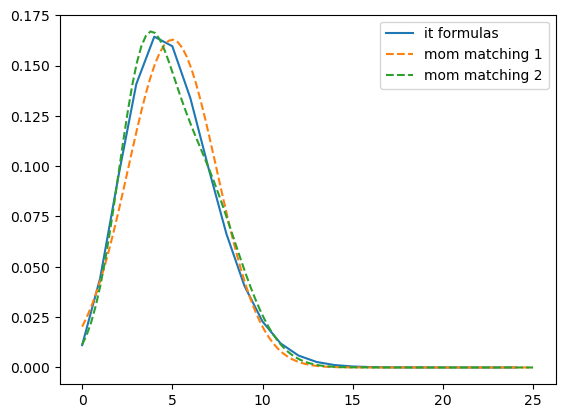

In [248]:
n_norm = 1000
n_pois = 100

norm_samples = norm.rvs(mu, sigma, size=n_norm)
pois_samples = []
for rate in norm_samples:
    pois_samples += list(poisson.rvs(rate, size = n_pois))
    
#plt.plot(range(supp), pois_it, marker='o', label='it formulas')
#plt.hist(pois_samples, bins=range(supp), density=True);
    
from sklearn.mixture import GaussianMixture
pois_samples = np.array(pois_samples).reshape(-1,1)
gm = GaussianMixture(n_components=2, random_state=0).fit(pois_samples)

def gm_pdf(x, gm):
    means = gm.means_
    covs = gm.covariances_
    weights = gm.weights_
    c = len(weights)
    
    return sum([weights[i]*norm.pdf(x, loc=means[i], scale=np.sqrt(covs[i][0])) for i in range(c)])

plt.plot(range(supp), pois_it, label='it formulas')
plt.plot(x, norm.pdf(x, loc1, scale), ls='--', label='mom matching 1')
#plt.plot(x, norm.pdf(x, loc2, scale), ls='--', label='mode matching')
plt.plot(x, gm_pdf(x, gm), ls='--', label='mom matching 2')
plt.legend()